# Method 6 - Best Ideas High Minus Low Concentration

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Herfindahl

inst_data['target_sq'] = inst_data['target'] ** 2
herf = inst_data.groupby(['datadate', 'institution_id'])['target_sq'].sum().rename('herf').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Market Relative Weight per Shumway, Szefler, Yuan 2009

%store -r mkt_exp_ret

valid_data = valid_data.merge(mkt_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Herf

best_ideas = best_ideas.merge(herf)
best_ideas['herf_pct'] = best_ideas.groupby('datadate')['herf'].rank(pct=True)
low_ideas = best_ideas[best_ideas['herf_pct'] < (1 / 3)]
high_ideas = best_ideas[best_ideas['herf_pct'] > (2 / 3)]

# Weight the best ideas equally

low_ideas['target'] = 1 / low_ideas.groupby('datadate')['institution_id'].transform('count')
high_ideas['target'] = 1 / high_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
low_w = weights.Weights(low_ideas)
high_w = weights.Weights(high_ideas)

%store -r r

low_p = portfolio.DailyPortfolio(low_w, r, end_date='2018-12-31')
high_p = portfolio.DailyPortfolio(high_w, r, end_date='2018-12-31')

monthly_return = (high_p.port_return - low_p.port_return).loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

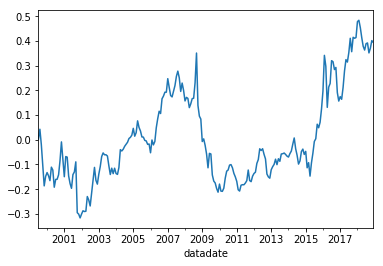

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31   -0.148195
2000-12-31    0.081161
2001-12-31   -0.257481
2002-12-31    0.199989
2003-12-31    0.078420
2004-12-31    0.151505
2005-12-31   -0.035326
2006-12-31    0.213221
2007-12-31    0.006378
2008-12-31   -0.096941
2009-12-31   -0.273027
2010-12-31    0.078871
2011-12-31    0.002890
2012-12-31   -0.009369
2013-12-31    0.105667
2014-12-31    0.007495
2015-12-31    0.195707
2016-12-31    0.028287
2017-12-31    0.222104
2018-12-31   -0.013758
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     7.556
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.82e-06
Time:                        14:20:23   Log-Likelihood:                 422.97
No. Observations:                 234   AIC:                            -835.9
Df Residuals:                     229   BIC:                            -818.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.003      0.547      0.585      -0.004       0.007
mktrf         -0.0572      0.075     -0.764      0.445      -0.205       0.090
me            -0.1024      0.087     -1.176      0.241      -0.274       0.069
ia             0.1233      0.132      0.932      0.352      -0.137       0.384
roe            0.3370      0.113      2.975      0.003       0.114       0.560
==============================================================================
Omnibus:                       69.029   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              275.003
Skew:                          -1.141   Prob(JB):                     1.92e-60
Kurtosis:                       7.795   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     3.727
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00585
Time:                        14:20:23   Log-Likelihood:                 422.97
No. Observations:                 234   AIC:                            -835.9
Df Residuals:                     229   BIC:                            -818.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.003      0.479      0.632      -0.005       0.008
mktrf         -0.0572      0.125     -0.457      0.647      -0.302       0.188
me            -0.1024      0.114     -0.898      0.369      -0.326       0.121
ia             0.1233      0.170      0.727      0.467      -0.209       0.456
roe            0.3370      0.135      2.493      0.013       0.072       0.602
==============================================================================
Omnibus:                       69.029   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              275.003
Skew:                          -1.141   Prob(JB):                     1.92e-60
Kurtosis:                       7.795   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     3.779
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00536
Time:                        14:20:23   Log-Likelihood:                 422.97
No. Observations:                 234   AIC:                            -835.9
Df Residuals:                     229   BIC:                            -818.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.003      0.463      0.643      -0.005       0.008
mktrf         -0.0572      0.126     -0.456      0.649      -0.303       0.189
me            -0.1024      0.125     -0.817      0.414      -0.348       0.143
ia             0.1233      0.188      0.655      0.513      -0.246       0.492
roe            0.3370      0.147      2.286      0.022       0.048       0.626
==============================================================================
Omnibus:                       69.029   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              275.003
Skew:                          -1.141   Prob(JB):                     1.92e-60
Kurtosis:                       7.795   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     6.497
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.14e-05
Time:                        14:20:24   Log-Likelihood:                 424.05
No. Observations:                 234   AIC:                            -836.1
Df Residuals:                     228   BIC:                            -815.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.003      0.570      0.569      -0.004       0.007
mktrf         -0.0744      0.075     -0.994      0.321      -0.222       0.073
smb           -0.1428      0.099     -1.446      0.149      -0.337       0.052
hml            0.0442      0.116      0.380      0.705      -0.185       0.274
rmw            0.2973      0.132      2.260      0.025       0.038       0.557
cma            0.0980      0.167      0.586      0.558      -0.232       0.428
==============================================================================
Omnibus:                       63.241   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              234.898
Skew:                          -1.060   Prob(JB):                     9.83e-52
Kurtosis:                       7.427   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     5.464
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.03e-05
Time:                        14:20:24   Log-Likelihood:                 424.05
No. Observations:                 234   AIC:                            -836.1
Df Residuals:                     228   BIC:                            -815.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.003      0.518      0.604      -0.004       0.008
mktrf         -0.0744      0.093     -0.798      0.425      -0.257       0.108
smb           -0.1428      0.135     -1.060      0.289      -0.407       0.121
hml            0.0442      0.209      0.211      0.833      -0.365       0.454
rmw            0.2973      0.169      1.755      0.079      -0.035       0.629
cma            0.0980      0.190      0.517      0.605      -0.274       0.470
==============================================================================
Omnibus:                       63.241   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              234.898
Skew:                          -1.060   Prob(JB):                     9.83e-52
Kurtosis:                       7.427   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     7.103
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.40e-06
Time:                        14:20:24   Log-Likelihood:                 424.05
No. Observations:                 234   AIC:                            -836.1
Df Residuals:                     228   BIC:                            -815.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.003      0.519      0.604      -0.004       0.008
mktrf         -0.0744      0.091     -0.820      0.412      -0.252       0.103
smb           -0.1428      0.147     -0.975      0.330      -0.430       0.144
hml            0.0442      0.205      0.216      0.829      -0.357       0.445
rmw            0.2973      0.161      1.852      0.064      -0.017       0.612
cma            0.0980      0.187      0.524      0.600      -0.269       0.465
==============================================================================
Omnibus:                       63.241   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              234.898
Skew:                          -1.060   Prob(JB):                     9.83e-52
Kurtosis:                       7.427   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     9.504
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.99e-07
Time:                        14:20:24   Log-Likelihood:                 426.43
No. Observations:                 234   AIC:                            -842.9
Df Residuals:                     229   BIC:                            -825.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.003      0.912      0.363      -0.003       0.008
mktrf         -0.0783      0.068     -1.154      0.250      -0.212       0.055
smb           -0.3076      0.085     -3.629      0.000      -0.475      -0.141
hml            0.1732      0.084      2.057      0.041       0.007       0.339
umd            0.1644      0.055      2.976      0.003       0.056       0.273
==============================================================================
Omnibus:                       55.039   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.587
Skew:                          -0.926   Prob(JB):                     5.57e-43
Kurtosis:                       7.065   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     4.787
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00100
Time:                        14:20:24   Log-Likelihood:                 426.43
No. Observations:                 234   AIC:                            -842.9
Df Residuals:                     229   BIC:                            -825.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.003      0.797      0.426      -0.004       0.008
mktrf         -0.0783      0.109     -0.718      0.473      -0.292       0.135
smb           -0.3076      0.127     -2.428      0.015      -0.556      -0.059
hml            0.1732      0.155      1.116      0.264      -0.131       0.477
umd            0.1644      0.066      2.494      0.013       0.035       0.294
==============================================================================
Omnibus:                       55.039   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.587
Skew:                          -0.926   Prob(JB):                     5.57e-43
Kurtosis:                       7.065   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     4.221
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00257
Time:                        14:20:24   Log-Likelihood:                 426.43
No. Observations:                 234   AIC:                            -842.9
Df Residuals:                     229   BIC:                            -825.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.003      0.784      0.433      -0.004       0.008
mktrf         -0.0783      0.110     -0.714      0.475      -0.293       0.137
smb           -0.3076      0.137     -2.251      0.024      -0.575      -0.040
hml            0.1732      0.165      1.047      0.295      -0.151       0.497
umd            0.1644      0.060      2.733      0.006       0.046       0.282
==============================================================================
Omnibus:                       55.039   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.587
Skew:                          -0.926   Prob(JB):                     5.57e-43
Kurtosis:                       7.065   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     4.131
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00365
Time:                        14:20:24   Log-Likelihood:                 203.62
No. Observations:                 120   AIC:                            -397.2
Df Residuals:                     115   BIC:                            -383.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.004     -0.328      0.743      -0.010       0.007
mktrf          0.0049      0.117      0.042      0.967      -0.226       0.236
me            -0.0689      0.115     -0.597      0.551      -0.297       0.160
ia             0.4341      0.181      2.404      0.018       0.076       0.792
roe            0.2148      0.160      1.344      0.182      -0.102       0.531
==============================================================================
Omnibus:                       39.025   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.047
Skew:                          -1.193   Prob(JB):                     2.09e-24
Kurtosis:                       7.015   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     3.980
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00462
Time:                        14:20:24   Log-Likelihood:                 203.62
No. Observations:                 120   AIC:                            -397.2
Df Residuals:                     115   BIC:                            -383.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.005     -0.293      0.769      -0.011       0.008
mktrf          0.0049      0.184      0.026      0.979      -0.356       0.366
me            -0.0689      0.148     -0.464      0.642      -0.360       0.222
ia             0.4341      0.187      2.318      0.020       0.067       0.801
roe            0.2148      0.147      1.458      0.145      -0.074       0.504
==============================================================================
Omnibus:                       39.025   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.047
Skew:                          -1.193   Prob(JB):                     2.09e-24
Kurtosis:                       7.015   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     4.216
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00320
Time:                        14:20:24   Log-Likelihood:                 203.62
No. Observations:                 120   AIC:                            -397.2
Df Residuals:                     115   BIC:                            -383.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.005     -0.281      0.778      -0.011       0.008
mktrf          0.0049      0.189      0.026      0.979      -0.365       0.374
me            -0.0689      0.159     -0.433      0.665      -0.381       0.243
ia             0.4341      0.180      2.413      0.016       0.082       0.787
roe            0.2148      0.157      1.371      0.170      -0.092       0.522
==============================================================================
Omnibus:                       39.025   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.047
Skew:                          -1.193   Prob(JB):                     2.09e-24
Kurtosis:                       7.015   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     6.182
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.16e-05
Time:                        14:20:24   Log-Likelihood:                 209.96
No. Observations:                 120   AIC:                            -407.9
Df Residuals:                     114   BIC:                            -391.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.004     -0.174      0.863      -0.009       0.008
mktrf         -0.0985      0.117     -0.840      0.403      -0.331       0.134
smb           -0.1741      0.133     -1.311      0.193      -0.437       0.089
hml            0.4416      0.163      2.713      0.008       0.119       0.764
rmw           -0.0527      0.192     -0.275      0.784      -0.433       0.328
cma            0.1388      0.210      0.660      0.511      -0.278       0.555
==============================================================================
Omnibus:                       27.588   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.714
Skew:                          -0.868   Prob(JB):                     3.26e-15
Kurtosis:                       6.214   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     8.470
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.65e-07
Time:                        14:20:24   Log-Likelihood:                 209.96
No. Observations:                 120   AIC:                            -407.9
Df Residuals:                     114   BIC:                            -391.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.004     -0.166      0.868      -0.009       0.008
mktrf         -0.0985      0.133     -0.739      0.460      -0.360       0.163
smb           -0.1741      0.176     -0.991      0.321      -0.518       0.170
hml            0.4416      0.153      2.878      0.004       0.141       0.742
rmw           -0.0527      0.200     -0.263      0.792      -0.446       0.340
cma            0.1388      0.159      0.874      0.382      -0.172       0.450
==============================================================================
Omnibus:                       27.588   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.714
Skew:                          -0.868   Prob(JB):                     3.26e-15
Kurtosis:                       6.214   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     10.57
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.35e-08
Time:                        14:20:24   Log-Likelihood:                 209.96
No. Observations:                 120   AIC:                            -407.9
Df Residuals:                     114   BIC:                            -391.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.005     -0.161      0.872      -0.010       0.008
mktrf         -0.0985      0.125     -0.786      0.432      -0.344       0.147
smb           -0.1741      0.191     -0.914      0.361      -0.548       0.199
hml            0.4416      0.126      3.515      0.000       0.195       0.688
rmw           -0.0527      0.178     -0.296      0.767      -0.402       0.296
cma            0.1388      0.141      0.987      0.324      -0.137       0.414
==============================================================================
Omnibus:                       27.588   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.714
Skew:                          -0.868   Prob(JB):                     3.26e-15
Kurtosis:                       6.214   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     8.999
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.33e-06
Time:                        14:20:24   Log-Likelihood:                 211.91
No. Observations:                 120   AIC:                            -413.8
Df Residuals:                     115   BIC:                            -399.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.004     -0.325      0.746      -0.009       0.007
mktrf         -0.0057      0.096     -0.059      0.953      -0.196       0.184
smb           -0.1980      0.109     -1.811      0.073      -0.414       0.019
hml            0.4659      0.109      4.256      0.000       0.249       0.683
umd            0.1423      0.067      2.109      0.037       0.009       0.276
==============================================================================
Omnibus:                       25.463   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.357
Skew:                          -0.840   Prob(JB):                     9.53e-13
Kurtosis:                       5.872   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     9.119
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.96e-06
Time:                        14:20:24   Log-Likelihood:                 211.91
No. Observations:                 120   AIC:                            -413.8
Df Residuals:                     115   BIC:                            -399.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.004     -0.288      0.773      -0.010       0.007
mktrf         -0.0057      0.124     -0.046      0.963      -0.249       0.237
smb           -0.1980      0.178     -1.114      0.265      -0.546       0.150
hml            0.4659      0.142      3.285      0.001       0.188       0.744
umd            0.1423      0.074      1.924      0.054      -0.003       0.287
==============================================================================
Omnibus:                       25.463   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.357
Skew:                          -0.840   Prob(JB):                     9.53e-13
Kurtosis:                       5.872   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     10.75
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.93e-07
Time:                        14:20:24   Log-Likelihood:                 211.91
No. Observations:                 120   AIC:                            -413.8
Df Residuals:                     115   BIC:                            -399.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.005     -0.278      0.781      -0.010       0.008
mktrf         -0.0057      0.125     -0.046      0.964      -0.250       0.239
smb           -0.1980      0.191     -1.037      0.300      -0.572       0.176
hml            0.4659      0.125      3.741      0.000       0.222       0.710
umd            0.1423      0.067      2.137      0.033       0.012       0.273
==============================================================================
Omnibus:                       25.463   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.357
Skew:                          -0.840   Prob(JB):                     9.53e-13
Kurtosis:                       5.872   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     10.28
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.21e-07
Time:                        14:20:24   Log-Likelihood:                 235.79
No. Observations:                 114   AIC:                            -461.6
Df Residuals:                     109   BIC:                            -447.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.003      1.379      0.171      -0.002       0.010
mktrf         -0.1426      0.092     -1.550      0.124      -0.325       0.040
me            -0.0766      0.142     -0.539      0.591      -0.358       0.205
ia            -0.3660      0.197     -1.858      0.066      -0.756       0.024
roe            0.7361      0.173      4.254      0.000       0.393       1.079
==============================================================================
Omnibus:                        3.844   Durbin-Watson:                   1.834
Prob(Omnibus):                  0.146   Jarque-Bera (JB):                3.988
Skew:                           0.182   Prob(JB):                        0.136
Kurtosis:                       3.841   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     10.13
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.21e-07
Time:                        14:20:24   Log-Likelihood:                 235.79
No. Observations:                 114   AIC:                            -461.6
Df Residuals:                     109   BIC:                            -447.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.003      1.544      0.123      -0.001       0.010
mktrf         -0.1426      0.091     -1.568      0.117      -0.321       0.036
me            -0.0766      0.189     -0.404      0.686      -0.448       0.295
ia            -0.3660      0.216     -1.693      0.090      -0.790       0.058
roe            0.7361      0.284      2.588      0.010       0.179       1.293
==============================================================================
Omnibus:                        3.844   Durbin-Watson:                   1.834
Prob(Omnibus):                  0.146   Jarque-Bera (JB):                3.988
Skew:                           0.182   Prob(JB):                        0.136
Kurtosis:                       3.841   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     10.11
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.36e-07
Time:                        14:20:24   Log-Likelihood:                 235.79
No. Observations:                 114   AIC:                            -461.6
Df Residuals:                     109   BIC:                            -447.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.002      2.008      0.045       0.000       0.008
mktrf         -0.1426      0.082     -1.729      0.084      -0.304       0.019
me            -0.0766      0.210     -0.364      0.716      -0.488       0.335
ia            -0.3660      0.246     -1.490      0.136      -0.847       0.115
roe            0.7361      0.312      2.358      0.018       0.124       1.348
==============================================================================
Omnibus:                        3.844   Durbin-Watson:                   1.834
Prob(Omnibus):                  0.146   Jarque-Bera (JB):                3.988
Skew:                           0.182   Prob(JB):                        0.136
Kurtosis:                       3.841   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     8.962
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.80e-07
Time:                        14:20:24   Log-Likelihood:                 237.32
No. Observations:                 114   AIC:                            -462.6
Df Residuals:                     108   BIC:                            -446.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.003      1.485      0.140      -0.002       0.011
mktrf         -0.1401      0.087     -1.612      0.110      -0.312       0.032
smb           -0.0547      0.141     -0.387      0.699      -0.334       0.225
hml           -0.5011      0.180     -2.784      0.006      -0.858      -0.144
rmw            0.6192      0.220      2.809      0.006       0.182       1.056
cma            0.0146      0.280      0.052      0.959      -0.540       0.569
==============================================================================
Omnibus:                        2.339   Durbin-Watson:                   1.782
Prob(Omnibus):                  0.311   Jarque-Bera (JB):                2.074
Skew:                           0.046   Prob(JB):                        0.355
Kurtosis:                       3.654   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     8.023
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.83e-06
Time:                        14:20:24   Log-Likelihood:                 237.32
No. Observations:                 114   AIC:                            -462.6
Df Residuals:                     108   BIC:                            -446.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.003      1.394      0.163      -0.002       0.011
mktrf         -0.1401      0.084     -1.674      0.094      -0.304       0.024
smb           -0.0547      0.161     -0.341      0.733      -0.369       0.260
hml           -0.5011      0.136     -3.671      0.000      -0.769      -0.234
rmw            0.6192      0.303      2.042      0.041       0.025       1.213
cma            0.0146      0.246      0.059      0.953      -0.468       0.497
==============================================================================
Omnibus:                        2.339   Durbin-Watson:                   1.782
Prob(Omnibus):                  0.311   Jarque-Bera (JB):                2.074
Skew:                           0.046   Prob(JB):                        0.355
Kurtosis:                       3.654   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     8.230
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.29e-06
Time:                        14:20:24   Log-Likelihood:                 237.32
No. Observations:                 114   AIC:                            -462.6
Df Residuals:                     108   BIC:                            -446.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.003      1.587      0.113      -0.001       0.010
mktrf         -0.1401      0.088     -1.598      0.110      -0.312       0.032
smb           -0.0547      0.176     -0.311      0.756      -0.400       0.290
hml           -0.5011      0.148     -3.386      0.001      -0.791      -0.211
rmw            0.6192      0.305      2.031      0.042       0.022       1.217
cma            0.0146      0.279      0.052      0.958      -0.532       0.561
==============================================================================
Omnibus:                        2.339   Durbin-Watson:                   1.782
Prob(Omnibus):                  0.311   Jarque-Bera (JB):                2.074
Skew:                           0.046   Prob(JB):                        0.355
Kurtosis:                       3.654   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     9.813
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.11e-07
Time:                        14:20:24   Log-Likelihood:                 235.07
No. Observations:                 114   AIC:                            -460.1
Df Residuals:                     109   BIC:                            -446.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.003      1.622      0.108      -0.001       0.011
mktrf         -0.1575      0.088     -1.796      0.075      -0.331       0.016
smb           -0.2053      0.137     -1.501      0.136      -0.476       0.066
hml           -0.4704      0.141     -3.340      0.001      -0.750      -0.191
umd            0.2000      0.106      1.883      0.062      -0.011       0.411
==============================================================================
Omnibus:                       12.952   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               28.412
Skew:                           0.367   Prob(JB):                     6.77e-07
Kurtosis:                       5.333   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     13.70
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.40e-09
Time:                        14:20:24   Log-Likelihood:                 235.07
No. Observations:                 114   AIC:                            -460.1
Df Residuals:                     109   BIC:                            -446.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.004      1.389      0.165      -0.002       0.012
mktrf         -0.1575      0.091     -1.739      0.082      -0.335       0.020
smb           -0.2053      0.153     -1.344      0.179      -0.505       0.094
hml           -0.4704      0.150     -3.135      0.002      -0.764      -0.176
umd            0.2000      0.120      1.661      0.097      -0.036       0.436
==============================================================================
Omnibus:                       12.952   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               28.412
Skew:                           0.367   Prob(JB):                     6.77e-07
Kurtosis:                       5.333   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     13.24
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.98e-09
Time:                        14:20:24   Log-Likelihood:                 235.07
No. Observations:                 114   AIC:                            -460.1
Df Residuals:                     109   BIC:                            -446.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.003      1.496      0.135      -0.002       0.012
mktrf         -0.1575      0.099     -1.595      0.111      -0.351       0.036
smb           -0.2053      0.156     -1.319      0.187      -0.510       0.100
hml           -0.4704      0.156     -3.022      0.003      -0.775      -0.165
umd            0.2000      0.101      1.988      0.047       0.003       0.397
==============================================================================
Omnibus:                       12.952   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               28.412
Skew:                           0.367   Prob(JB):                     6.77e-07
Kurtosis:                       5.333   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""